## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functionsCopy as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot

## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [3]:
cptac.download(dataset='ovarian')

True

In [4]:
ov = cptac.Ovarian()
proteomics = ov.get_proteomics()
transcriptomics = ov.get_transcriptomics()
clinical = ov.get_clinical()

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [5]:
#Create a copy of the original Clinical DataFrame
annotations = pd.DataFrame(clinical.copy())

In [6]:
#Drop irrelevant columns.
irrelevant_cols = ['Patient_ID', 'Participant_Gender', 'Histological_Subtype']
annotations = annotations.drop(irrelevant_cols, axis=1)

#Determine which columns we should either drop, or be generally skeptical of in our analysis
questionable_cols = ['Participant_History_Neo-adjuvant_Treatment', 
                     'Participant_History_Radiation_Therapy', 
                     'Participant_History_Hormonal_Therapy', 
                     'Participant_Ethnicity', 
                     'Normal_Sample_4_Surgical_Devascularized_Time', 
                     'Normal_Sample_4_Weight', 'Normal_Sample_4_LN2_Time', 
                     'Normal_Sample_4_Ischemia_Time', 
                     'Normal_Sample_5_Surgical_Devascularized_Time', 
                     'Normal_Sample_5_Weight', 'Normal_Sample_5_LN2_Time', 
                     'Normal_Sample_5_Ischemia_Time', 
                     'Other_New_Tumor_Event_Site', 
                     'Days_Between_Collection_And_New_Tumor_Event_Surgery', 
                     'Blood_Collection_Time', 
                     'Blood_Collection_Method', 
                     'Anesthesia_Time', 
                     'Tumor_Surgical_Devascularized_Time', 
                     'Tumor_Sample_Number', 
                     'Tumor_Sample_1_Weight', 
                     'Tumor_Sample_1_LN2_Time', 
                     'Tumor_Sample_1_Ischemia_Time', 
                     'Tumor_Sample_2_Weight', 
                     'Tumor_Sample_2_LN2_Time', 
                     'Tumor_Sample_2_Ischemia_Time', 
                     'Tumor_Sample_3_Weight', 
                     'Tumor_Sample_3_LN2_Time', 
                     'Tumor_Sample_3_Ischemia_Time', 
                     'Tumor_Sample_4_Weight',
                     'Tumor_Sample_4_LN2_Time', 
                     'Tumor_Sample_4_Ischemia_Time', 
                     'Tumor_Sample_5_Weight', 
                     'Tumor_Sample_5_LN2_Time', 
                     'Tumor_Sample_5_Ischemia_Time', 
                     'Normal_Sample_Number', 
                     'Normal_Sample_1_Surgical_Devascularized_Time', 
                     'Normal_Sample_1_Weight', 'Normal_Sample_1_LN2_Time', 
                     'Normal_Sample_1_Ischemia_Time', 
                     'Normal_Sample_2_Surgical_Devascularized_Time', 
                     'Normal_Sample_2_Weight', 'Normal_Sample_2_LN2_Time', 
                     'Normal_Sample_2_Ischemia_Time', 
                     'Normal_Sample_3_Surgical_Devascularized_Time', 
                     'Normal_Sample_3_Weight', 'Normal_Sample_3_LN2_Time', 
                     'Normal_Sample_3_Ischemia_Time', 
                     'Review_Of_Initial_Pathological_Findings', 
                     'Pathology_Review_Consistent_With_Diagnosis', 
                     'Adjuvant_Radiation_Therapy', 
                     'Adjuvant_Pharmaceutical_Therapy', 'Adjuvant_Immunotherapy', 
                     'Adjuvant_Hormone_Therapy', 'Adjuvant_Targeted_Molecular_Therapy']

annotations = annotations.drop(questionable_cols, axis=1)

In [7]:
#Determine which columns are binary and which aren't
binary_cols = []
non_binary_cols = []

for col in annotations.columns:
    if len(annotations[col].value_counts()) == 2:
        binary_cols.append(col)
    elif len(annotations[col].value_counts()) > 2:
        non_binary_cols.append(col)
    else:
        annotations = annotations.drop(col, axis=1) 
        #This would defeat the purpose of binarization if there were only 1 possible outcome.

In [8]:
numeric_non_bin = []
categorical_non_bin = []

for item in non_binary_cols:
    if np.issubdtype(annotations[item].dtype, np.number):
        print(item+" is a numeric column\n")
        numeric_non_bin.append(item)
        mean = annotations[item].mean()
        annotations[item]= bf.binarizeCutOff(annotations, item, mean, 
                                             "Above_Mean("+str(round(mean, 2))+")", 
                                             "Below_Mean("+str(round(mean, 2))+")")
    else:
        print(item+" is a categorical column\n")
        categorical_non_bin.append(item)

Participant_Procurement_Age is a numeric column

Participant_Race is a categorical column

Participant_Jewish_Heritage is a categorical column

Aliquots_Plasma is a numeric column

Origin_Site_Disease is a categorical column

Anatomic_Site_Tumor is a categorical column

Anatomic_Lateral_Position_Tumor is a categorical column

Method_of_Pathologic_Diagnosis is a categorical column

Tumor_Stage_Ovary_FIGO is a categorical column

Tumor_Grade is a categorical column

Tumor_Residual_Disease_Max_Diameter is a categorical column

Days_Between_Collection_And_Last_Contact is a numeric column

Days_Between_Collection_And_Death is a numeric column

Tumor_Status is a categorical column

Response_After_Surgery_And_Adjuvant_Therapies is a categorical column

New_Tumor_Event_After_Initial_Treatment is a categorical column

New_Tumor_Event_Type is a categorical column

New_Tumor_Event_Site is a categorical column

Days_Between_Collection_And_New_Tumor_Event is a numeric column

New_Tumor_Event_Diagno

## Step 2a: Binarize column values

In [9]:
race_map = {'White':'White', 
            'Asian':'Not_White', 
            'Black or African American':'Not_White', 
            'Unknown (Could not be determined or unsure)':np.nan, 
            'American Indian or Alaska Native': 'Not_White'}

annotations['Participant_Race'] = bf.binarizeCategorical(annotations, 
                                                         'Participant_Race', 
                                                         race_map)

In [10]:
jewish_map = {'Not Jewish':'Not_Jewish', 
              'Unknown':np.nan, 
              'Ashkenazi':'Jewish', 
              'Jewish, NOS':'Jewish'}

annotations['Participant_Jewish_Heritage'] = bf.binarizeCategorical(annotations, 
                                                                    'Participant_Jewish_Heritage', 
                                                                    jewish_map)

In [11]:
origin_site_map = {'Ovary':'Ovary', 
                   'Fallopian tube':'Other', 
                   'Peritoneum':'Other'}

annotations['Origin_Site_Disease'] = bf.binarizeCategorical(annotations, 
                                                            'Origin_Site_Disease',
                                                            origin_site_map)

In [12]:
anatomic_site_map = {'Ovary':'Ovary', 
                     'Omentum':'Other', 
                     'Pelvic mass':'Other', 
                     'Peritoneum':'Other', 
                     'Not Reported/ Unknown':np.nan}

annotations['Anatomic_Site_Tumor'] = bf.binarizeCategorical(annotations, 
                                                            'Anatomic_Site_Tumor',
                                                            anatomic_site_map)

In [13]:
anatomic_lateral_map = {'Not applicable':'Other',
                        'Right':'Right',
                        'Left':'Other', 
                        'Not Reported/ Unknown':np.nan, 
                        'Bilateral':'Other'}

annotations['Anatomic_Lateral_Position_Tumor'] = bf.binarizeCategorical(annotations,
                                                                        'Anatomic_Lateral_Position_Tumor',
                                                                        anatomic_lateral_map)

In [14]:
path_diagnosis_map = {'Tumor resection': 'Tumor resection',
                      'Excisional Biopsy':'Biopsy', 
                      'Excisional Biopsy':'Biopsy'}

annotations['Method_of_Pathologic_Diagnosis'] = bf.binarizeCategorical(annotations,
                                                                       'Method_of_Pathologic_Diagnosis',
                                                                       path_diagnosis_map)

In [15]:
tumor_stage_map = {'IC':'I_or_II', 
                   'IIB':'I_or_II', 
                   'III':'III_or_IV', 
                   'IIIA':'III_or_IV', 
                   'IIIB':'III_or_IV', 
                   'IIIC':'III_or_IV', 
                   'IV':'III_or_IV', 
                   'Not Reported/ Unknown':np.nan}

annotations['Tumor_Stage_Ovary_FIGO'] = bf.binarizeCategorical(annotations, 
                                                               'Tumor_Stage_Ovary_FIGO', 
                                                               tumor_stage_map)

In [16]:
tumor_grade_map = {'G3':'G3', 'Not Reported/ Unknown':np.nan, 
                   'G2':'Other', 'G1':'Other', 
                   'GB':'Other', 'GX':'Other'}

annotations['Tumor_Grade'] = bf.binarizeCategorical(annotations, 
                                                    'Tumor_Grade', 
                                                    tumor_grade_map)

In [17]:
resid_max_diam_map = {'None':'0-10 mm', 
                      '1-10 mm': '0-10 mm', 
                      'greater than 20 mm':'greater than 11 mm', 
                      'Not Reported/ Unknown':np.nan, 
                      '11-20 mm':'greater than 11 mm'}

annotations['Tumor_Residual_Disease_Max_Diameter'] = bf.binarizeCategorical(annotations, 
                                                                            'Tumor_Residual_Disease_Max_Diameter', 
                                                                            resid_max_diam_map)

In [18]:
annotations['Tumor_Status'] = annotations['Tumor_Status'].replace('Not Reported/Unknown', np.nan)

In [19]:
response_map = {'Complete Response':'Complete_or_Partial_Response', 
                'Partial Response':'Complete_or_Partial_Response', 
                'Stable Disease':'Stable_or_Progressive_Disease', 
                'Not Reported/Unknown':np.nan, 
                'Progressive Disease':'Stable_or_Progressive_Disease'}

annotations['Response_After_Surgery_And_Adjuvant_Therapies'] = bf.binarizeCategorical(annotations, 
                                                                                      'Response_After_Surgery_And_Adjuvant_Therapies', 
                                                                                      response_map)

In [20]:
new_tumor_map = {'No':'No', 'Yes':'Yes',
                 'Not Reported/Unknown':np.nan, 
                 'Not Applicable':np.nan}

annotations['New_Tumor_Event_After_Initial_Treatment'] = bf.binarizeCategorical(annotations, 
                                                                                'New_Tumor_Event_After_Initial_Treatment',
                                                                                new_tumor_map)

In [21]:
new_tumor_type_map = {'Locoregional Disease':'Locoregional_and_or_Distant_Metastasis', 
                      'Both Locoregional and Distant Metastasis':'Locoregional_and_or_Distant_Metastasis',
                      'Metastatic':'Metastatic', 'Not Reported/Unknown':np.nan}

annotations['New_Tumor_Event_Type'] = bf.binarizeCategorical(annotations,
                                                             'New_Tumor_Event_Type',
                                                             new_tumor_type_map)

In [22]:
new_tumor_site_map = {'Abdomen':'Abdomen', 
                      'Chest; Abdomen':'Abdomen', 
                      'Lymph Node only (specify location)':'Other', 
                      'Other (specify)':'Other', 
                      'Abdomen; Chest':'Abdomen', 
                      'Other (specify); Chest':'Other', 
                      'Abdomen; Other (specify); Pelvis':'Abdomen', 
                      'Pelvis; Abdomen':'Abdomen'}

annotations['New_Tumor_Event_Site'] = bf.binarizeCategorical(annotations,
                                                             'New_Tumor_Event_Site',
                                                             new_tumor_site_map)

In [23]:
diagnosis_map = {'Convincing imaging':'Convincing imaging', 
                 'Positive Biomarkers':'Biomarkers_or_Seen_at_Surgery', 
                 'First seen at further surgery':'Biomarkers_or_Seen_at_Surgery'}

annotations['New_Tumor_Event_Diagnosis'] = bf.binarizeCategorical(annotations, 
                                                                  'New_Tumor_Event_Diagnosis', 
                                                                  diagnosis_map)

In [24]:
annotations['New_Tumor_Event_Surgery'] = annotations['New_Tumor_Event_Surgery'].replace('Not Reported/Unknown', np.nan)

In [25]:
annotations['New_Tumor_Event_Chemotherapy'] = annotations['New_Tumor_Event_Chemotherapy'].replace('Not Reported/Unknown', np.nan)

In [26]:
annotations['New_Tumor_Event_Immunotherapy'] = annotations['New_Tumor_Event_Immunotherapy'].replace('Not Reported/Unknown', np.nan)

In [27]:
annotations['New_Tumor_Event_Targeted_Molecular_Therapy'] = annotations['New_Tumor_Event_Targeted_Molecular_Therapy'].replace('Not Reported/Unknown', np.nan)

## Step 3: Perform outliers analysis

In [28]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

## Step 4: Wrap your A/B test into the outliers analysis, and create a table
First for proteomics, and then phosphoproteomics.

In [29]:
'''
This will break if there are duplicate gene names. Be sure to use the renameDuplicateColumns
function if there are errors with indexing when compare_groups_outliers runs
'''
bf.renameDuplicateColumns(outliers_prot)
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

There are no duplicates


Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [30]:
results_prot = results_prot.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

In [31]:
#Drop Columns with less than 5 significant enrichments
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.01)
    if sig_col is not None and len(sig_col) >= 5:
        sig_cols.append(sig_col)
        print(sig_col)
    else:
        results_prot = results_prot.drop(col, axis=1)

TESTING FOR PROTEOMICS:
                     Sample_Tumor_Normal_Normal_P_values
Name   Database_ID                                      
A1BG   NP_570602                            1.530112e-06
ABCA8  NP_001275914                         7.415921e-09
ABHD5  NP_057090                            2.160272e-03
ABI3BP NP_056244                            2.768223e-07
ABL1   NP_005148                            2.141254e-04
...                                                  ...
VWA1   NP_073745                            9.377851e-05
WDR54  NP_001307752                         2.141254e-04
WFS1   NP_001139325                         2.768223e-07
WISP2  NP_003872                            9.958964e-06
ZBTB47 NP_660149                            3.566993e-04

[538 rows x 1 columns]
                       Participant_History_Malignancy_Yes, History of Other Cancer Greater Than One Year Ago_P_values
Name     Database_ID                                                                         

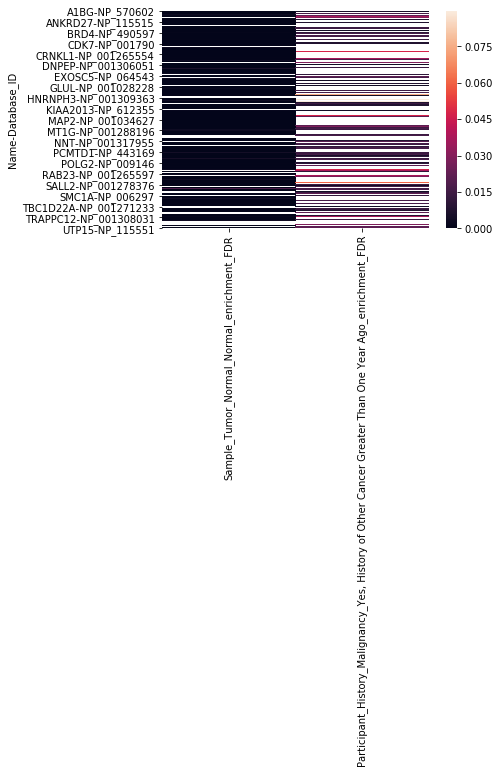

In [32]:
sns.heatmap(results_prot)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [33]:
for col in sig_cols:
    col_name = col.columns[0]
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/ovarian')
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name)

TypeError: sequence item 0: expected str instance, tuple found